Copyright 2019 The Dopamine Authors.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

# Dopamine: How to train an agent on Cartpole

This colab demonstrates how to train the DQN and C51 on Cartpole, based on the default configurations provided.

The hyperparameters chosen are by no mean optimal. The purpose of this colab is to illustrate how to train two
agents on a non-Atari gym environment: cartpole.

We also include default configurations for Acrobot in our repository: https://github.com/google/dopamine

Run all the cells below in order.

In [4]:
!pip install git+https://github.com/openai/baselines@tf2

  Cloning https://github.com/openai/baselines (to revision tf2) to /tmp/pip-req-build-bnranicl
  Running command git clone --filter=blob:none --quiet https://github.com/openai/baselines /tmp/pip-req-build-bnranicl
  Running command git checkout -b tf2 --track origin/tf2
  Switched to a new branch 'tf2'
  Branch 'tf2' set up to track remote branch 'tf2' from 'origin'.
  Resolved https://github.com/openai/baselines to commit b99a73afe37206775ac8b884d32a36e213a3fac2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 32.4 MB/s eta 0:00:00
  Created wheel for baselines: filename=baselines-0.1.5

In [2]:
# @title Install necessary packages.
!pip install git+https://github.com/google/dopamine.git


  Cloning https://github.com/google/dopamine.git to /tmp/pip-req-build-51f4asly
  Running command git clone --filter=blob:none --quiet https://github.com/google/dopamine.git /tmp/pip-req-build-51f4asly
  Resolved https://github.com/google/dopamine.git to commit bec5f4e108b0572e58fc1af73136e978237c8463
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.5/734.5 kB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
# @title Necessary imports and globals.

import numpy as np
import os
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin
import dopamine
BASE_PATH = '/tmp/colab_dopamine_run'  # @param

## Train DQN

In [6]:
# @title Load the configuration for DQN.

DQN_PATH = os.path.join(BASE_PATH, 'dqn')
# Modified from dopamine/jax/agents/dqn/config/dqn_cartpole.gin
dqn_config = """
# Hyperparameters for a simple DQN-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.jax.agents.dqn.dqn_agent
import dopamine.jax.networks
import dopamine.tf.replay_memory.circular_replay_buffer

JaxDQNAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
JaxDQNAgent.observation_dtype = %jax_networks.CARTPOLE_OBSERVATION_DTYPE
JaxDQNAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
JaxDQNAgent.network = @networks.ClassicControlDQNNetwork
JaxDQNAgent.gamma = 0.99
JaxDQNAgent.update_horizon = 1
JaxDQNAgent.min_replay_history = 500
JaxDQNAgent.update_period = 4
JaxDQNAgent.target_update_period = 100
JaxDQNAgent.epsilon_fn = @dopamine.jax.agents.dqn.dqn_agent.identity_epsilon
JaxDQNAgent.optimizer = 'adam'

ClassicControlDQNNetwork.min_vals = %jax_networks.CARTPOLE_MIN_VALS
ClassicControlDQNNetwork.max_vals = %jax_networks.CARTPOLE_MAX_VALS

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v0'
create_runner.schedule = 'continuous_train'
create_agent.agent_name = 'jax_dqn'
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 200  # Default max episode length.

ReplayBuffer.max_capacity = 50_000
ReplayBuffer.batch_size = 128
"""

gin.parse_config(dqn_config, skip_unknown=False)

([],
 ['dopamine.discrete_domains.gym_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.jax.agents.dqn.dqn_agent',
  'dopamine.jax.networks',
  'dopamine.tf.replay_memory.circular_replay_buffer'])

In [7]:
# @title Train DQN on Cartpole
dqn_runner = run_experiment.create_runner(DQN_PATH, schedule='continuous_train')
print('Will train DQN agent, please be patient, may be a while...')
dqn_runner.run_experiment()
print('Done training!')

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Will train DQN agent, please be patient, may be a while...


  0%|          | 0/50 [00:00<?, ?it/s]

Done training!


# Train C51

In [9]:
# @title Load the configuration for C51.

C51_PATH = os.path.join(BASE_PATH, 'c51')
# Modified from dopamine/jax/agents/rainbow/config/c51_cartpole.gin
c51_config = """
# Hyperparameters for a simple C51-style Cartpole agent. The hyperparameters
# chosen achieve reasonable performance.
import dopamine.jax.agents.dqn.dqn_agent
import dopamine.jax.agents.rainbow.rainbow_agent
import dopamine.discrete_domains.gym_lib
import dopamine.discrete_domains.run_experiment
import dopamine.jax.networks
import dopamine.tf.replay_memory.prioritized_replay_buffer

JaxRainbowAgent.observation_shape = %gym_lib.CARTPOLE_OBSERVATION_SHAPE
JaxRainbowAgent.observation_dtype = %jax_networks.CARTPOLE_OBSERVATION_DTYPE
JaxRainbowAgent.stack_size = %gym_lib.CARTPOLE_STACK_SIZE
JaxRainbowAgent.network = @networks.ClassicControlRainbowNetwork
JaxRainbowAgent.num_atoms = 201
JaxRainbowAgent.vmax = 100.
JaxRainbowAgent.gamma = 0.99
JaxRainbowAgent.epsilon_eval = 0.
JaxRainbowAgent.epsilon_train = 0.01
JaxRainbowAgent.update_horizon = 1
JaxRainbowAgent.min_replay_history = 500
JaxRainbowAgent.update_period = 1
JaxRainbowAgent.target_update_period = 1
JaxRainbowAgent.epsilon_fn = @dopamine.jax.agents.dqn.dqn_agent.identity_epsilon
JaxRainbowAgent.replay_scheme = 'uniform'
create_optimizer.learning_rate = 0.00001
create_optimizer.eps = 0.00000390625

ClassicControlRainbowNetwork.min_vals = %jax_networks.CARTPOLE_MIN_VALS
ClassicControlRainbowNetwork.max_vals = %jax_networks.CARTPOLE_MAX_VALS

create_gym_environment.environment_name = 'CartPole'
create_gym_environment.version = 'v0'
create_runner.schedule = 'continuous_train'
create_agent.agent_name = 'jax_rainbow'
TrainRunner.create_environment_fn = @gym_lib.create_gym_environment
Runner.num_iterations = 50
Runner.training_steps = 1000
Runner.evaluation_steps = 1000
Runner.max_steps_per_episode = 200  # Default max episode length.

ReplayBuffer.max_capacity = 50_000
ReplayBuffer.batch_size = 128
PrioritizedSamplingDistribution.max_capacity = 50_000
"""
gin.parse_config(c51_config, skip_unknown=False)

([],
 ['dopamine.jax.agents.dqn.dqn_agent',
  'dopamine.jax.agents.rainbow.rainbow_agent',
  'dopamine.discrete_domains.gym_lib',
  'dopamine.discrete_domains.run_experiment',
  'dopamine.jax.networks',
  'dopamine.tf.replay_memory.prioritized_replay_buffer'])

In [10]:
# @title Train C51 on Cartpole
c51_runner = run_experiment.create_runner(C51_PATH, schedule='continuous_train')
print('Will train agent, please be patient, may be a while...')
c51_runner.run_experiment()
print('Done training!')

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Will train agent, please be patient, may be a while...


  0%|          | 0/50 [00:00<?, ?it/s]

Done training!


# Plot the results

In [11]:
# @title Load the training logs.
data = colab_utils.read_experiment(DQN_PATH, verbose=True,
                                   summary_keys=['train_episode_returns'])
data['agent'] = 'DQN'
data['run'] = 1
c51_data = colab_utils.read_experiment(C51_PATH, verbose=True,
                                       summary_keys=['train_episode_returns'])
c51_data['agent'] = 'C51'
c51_data['run'] = 1
data = data.merge(c51_data, how='outer')

Reading statistics from: /tmp/colab_dopamine_run/dqn//logs/log_49
Reading statistics from: /tmp/colab_dopamine_run/c51//logs/log_49


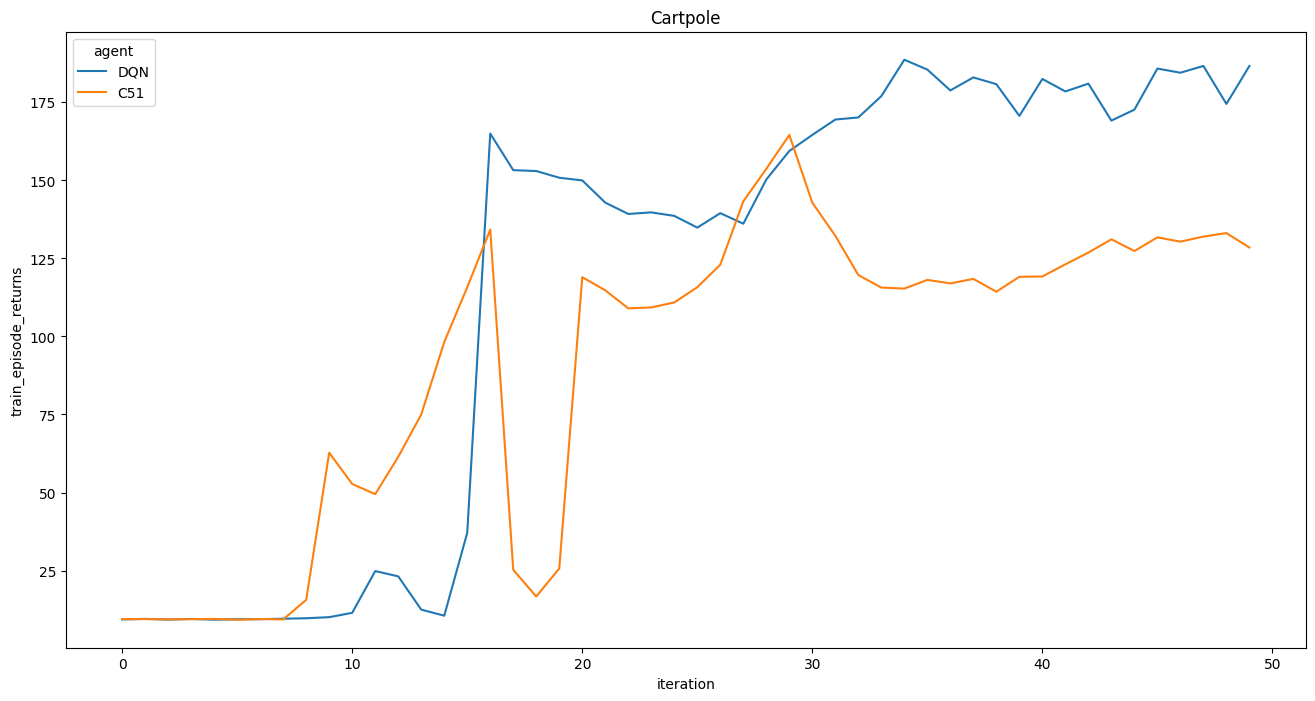

In [12]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x='iteration', y='train_episode_returns', hue='agent',
             data=data, ax=ax)
plt.title('Cartpole')
plt.show()